### 1) Implementation

In [ ]:
with open("shift_image.py", "r") as f:
    print(f.read())

import matplotlib.pyplot as plt
from mpi4py import MPI
import numpy as np
import tracemalloc
import imageio
import sys
import os

dir_name = 'pics/'

comm = MPI.COMM_WORLD
size = comm.size
rank = comm.Get_rank()

# if rank == 0:
#     start = MPI.Wtime()

tracemalloc.start()

img = plt.imread(sys.argv[1]).transpose([1, 0, 2]) if rank == 0 else None

row_size = img.shape[1] if rank == 0 else None
row_size = comm.bcast(row_size, root=0)

col_size = img.shape[0] if rank == 0 else None
col_size = comm.bcast(col_size, root=0)

displ = None
count = np.empty(size, dtype=int)

if rank == 0:
    quot, rem = divmod(img.shape[0], size)

    for r in range(size):
        count[r] = quot + 1 if r < rem else quot
    displ = np.array([np.sum(count[:r]) for r in range(size)])

comm.Bcast(count, root=0)

img_part = np.zeros(count[rank] * row_size * 3, dtype=np.uint8)

if rank == 0:
    arg1, arg2 = count*row_size*3,  displ*row_size*3
    comm.Scatterv([np.ascontiguousarray(img), arg1, arg2, MPI.UINT8_

### 2) Speedup

In [38]:
import matplotlib.pyplot as plt
import numpy as np

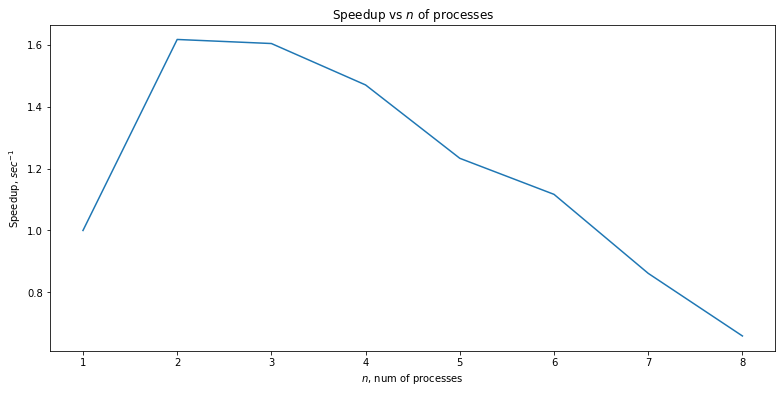

In [39]:
seq_time = None
time_list = []
size_list = []

with open('times.csv', 'r') as f:
  
  for row_id, line in enumerate(f.readlines()):
    data = line.split(',')
    size, time = np.float(data[0]), np.float(data[-1])
    if row_id == 0:
      seq_time = time

    time_list.append(time)
    size_list.append(size)
  

speedup_list = seq_time / np.array(time_list)

plt.figure(figsize=(13, 6))

plt.plot(size_list, speedup_list)

plt.title('Speedup vs $n$ of processes')
plt.ylabel('Speedup, $sec^{-1}$')
plt.xlabel('$n$, num of processes')

plt.show()

#### Explanation: in my implementation i used $\texttt{numpy.roll()}$ function to cyclically rotate pictures. And if we look on how it implemented inside python, we could see, that is uses multithreading approaches, which is avoiding GIL as they are designed on different from python language. So there are no restrictions to those functions to use all the machine's resourses. From that, we could conclude, that it leads to performance degradation as it is way to effective to use multithreding for only 1 process, instead of, let's say about my MacOS, 8 processes.

### 3) Memory consumption per 1 process

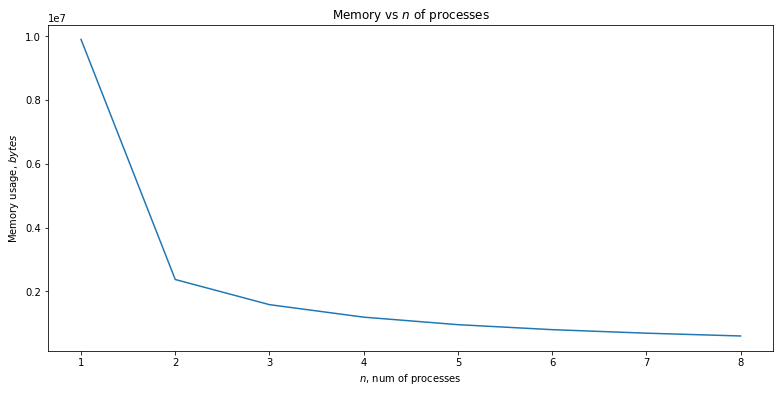

In [40]:
seq_time = None
mems_list = []
size_list = []

with open('memories.csv', 'r') as f:
  
  for row_id, line in enumerate(f.readlines()):
    data = line.split(',')
    size, mem = np.float(data[0]), np.float(data[-1])
    
    mems_list.append(mem)
    size_list.append(size)
  
plt.figure(figsize=(13, 6))

plt.plot(size_list, mems_list)

plt.title('Memory vs $n$ of processes')
plt.ylabel('Memory usage, $bytes$')
plt.xlabel('$n$, num of processes')

plt.show()

Concluding from what we see is that our approach distribution does make sense in terms of reduction of used memory in subtasks